# Importing Libraries and Defining Forward Kinematics Function


Here we imports necessary libraries and defines the n_link_forward_kinematics function. This function computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula. It takes joint angles, screw axes parameters, initial transformation parameters, and an epsilon value as inputs, and returns the homogeneous transformation matrix representing the end-effector configuration in the space frame.
The function iterates through each joint, creates Pose3 objects from screw axes, and multiplies them to get the final transformation. It then applies the initial transformation to get the end-effector pose.

In [66]:
import symforce

symforce.set_symbolic_api("sympy")

import symforce.symbolic as sf
from symforce.notebook_util import display
from symforce import geo
from symforce import values
from symforce.geo.unsupported.pose3_se3 import Pose3_SE3

def n_link_forward_kinematics(joint_angles: values.Values, screw_axes_params: values.Values, M_params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula,
    with symbolic parameters for joint angles, screw axes, and the initial transformation.

    Args:
        joint_angles: A Values object containing symbolic joint angles, with keys "q0", "q1", etc.
        screw_axes_params: A Values object containing symbolic parameters for the screw axes.
                         Each key should be of the form "S{i}", where i is the joint index, 
                         and the value should be a 6-vector representing the screw axis [omega_x, omega_y, omega_z, v_x, v_y, v_z].
        M_params: A Values object containing symbolic parameters for the initial transformation matrix M.
                  The keys should be "R" for the rotation (as a 3-vector Euler angles) and "t" for the translation (as a 3-vector).
        epsilon: A small number to handle singularities in Rot3.from_tangent.

    Returns:
        The homogeneous transformation matrix representing the end-effector configuration in the space frame.
    """
    T = sf.Pose3.identity()
    n = len(joint_angles)

    for i in range(n):
        # Extract screw axis parameters and joint angle from Values objects
        S = screw_axes_params[f"S{i+1}"]
        q = joint_angles[f"q{i+1}"]
        
        # Create se3 element (6x1 vector)
        se3_element = sf.Matrix61(S * q)

        # Create a Pose3_SE3 object from the se3 element
        pose3_se3 = Pose3_SE3.from_tangent(se3_element, epsilon=epsilon)

        # Convert Pose3_SE3 to Pose3
        pose3 = sf.Pose3(R=pose3_se3.R, t=pose3_se3.t)

        # Update the transformation
        T = T * pose3

    # Construct the initial transformation matrix from symbolic parameters
    R = geo.Rot3.from_yaw_pitch_roll(*M_params["R"])  
    t = geo.V3(M_params["t"])
    M = geo.Pose3(R=R, t=t)

    # Multiply with the initial transformation matrix
    T = T * M

    # Convert to homogeneous matrix at the end
    return T.to_homogenous_matrix()

# Example usage (adjust as needed for your specific case)
joint_angles = values.Values(
    q1=sf.Symbol("q1"),
    q2=sf.Symbol("q2"),
    q3=sf.Symbol("q3"),
)

screw_axes_params = values.Values(
    S1=sf.V6.symbolic("S1"),
    S2=sf.V6.symbolic("S2"),
    S3=sf.V6.symbolic("S3"),
)

M_params = values.Values(
    R=sf.V3.symbolic("R"),
    t=sf.V3.symbolic("t"),
)

epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

display(f"End-Effector Pose:\n{end_effector_pose}")

End-Effector Pose:
Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# Setting Up 3-DOF Robot Configuration

Here we defines the setup_3dof_robot() function, which sets up the configuration for a 3-DOF (Degrees of Freedom) robot. It defines symbolic variables for joint angles and link lengths, and creates Values objects for joint angles, screw axes parameters, and initial transformation parameters.
The robot has two revolute joints (rotating around y and x axes) and one prismatic joint (moving along z-axis). The function returns these parameters along with a symbolic variable for the end-effector's initial z-position ($L_0$).

In [67]:
def setup_3dof_robot():
    # Define symbolic variables for joint angles and link lengths
    theta1, theta2, d = sf.symbols("theta1 theta2 d",positive=True)
    # a1, a2, a3 = sf.symbols("a1 a2 a3")
    L0 = sf.symbols("L0",positive=True)  # EE position in base frame when in home position

    # Define joint angles
    joint_angles = values.Values(
        q1=theta1,
        q2=theta2,
        q3=d
    )

# Define screw axes for planar RRR robot
    # axis of rotation for revolute joint1
    omega1 = sf.V3(0, 1, 0)

    # Calculate v for each joint
    q1 = sf.V3(0, 0, 0)  # Point on the axis of joint 1
    v1 = -omega1.cross(q1)

    # axis of rotation for revolute joint2
    omega2 = sf.V3(1, 0, 0)

    q2 = sf.V3(0, 0, 0)  # Point on the axis of joint 2
    v2 = -omega2.cross(q2)


    # axis of rotation for prismatic joint3
    omega3 = sf.V3(0, 0, 0)    

    v3 = sf.V3(0, 0, 1)  # Prismatic joint moves along z-axis

    screw_axes_params = values.Values(
        S1=sf.V6(omega1.to_flat_list() + v1.to_flat_list()),
        S2=sf.V6(omega2.to_flat_list() + v2.to_flat_list()),
        S3=sf.V6(omega3.to_flat_list() + v3.to_flat_list())
    )

    # Define initial end-effector transformation (identity in this case)
    M_params = values.Values(
        R=sf.V3([0, 0, 0]),  # No initial rotation
        t=sf.V3([0, 0, L0])  # End-effector at full extension
    )

    return joint_angles, screw_axes_params, M_params, (L0)



# Computing Forward Kinematics

This cell uses the previously defined functions to compute the forward kinematics of the 3-DOF robot. It first sets up the robot configuration, then computes the end-effector pose using the n_link_forward_kinematics function. Finally, it displays the full end-effector pose, as well as the rotation matrix and translation vector separately.

'End-Effector Pose:\n<bound method Matrix.simplify of Matrix([\n[                                                                                    -2.0*theta1**2*theta2**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)**2*sin(sqrt(theta2**2 + 4.93038065763132e-30)/2)**2/((theta1**2 + 4.93038065763132e-30)*(theta2**2 + 4.93038065763132e-30)) - 2.0*theta1**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)**2*cos(sqrt(theta2**2 + 4.93038065763132e-30)/2)**2/(theta1**2 + 4.93038065763132e-30) + 1,                                                                                                                                                       4.0*theta1*theta2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)*sin(sqrt(theta2**2 + 4.93038065763132e-30)/2)*cos(sqrt(theta1**2 + 4.93038065763132e-30)/2)*cos(sqrt(theta2**2 + 4.93038065763132e-30)/2)/(sqrt(theta1**2 + 4.93038065763132e-30)*sqrt(theta2**2 + 4.93038065763132e-30)), -2.0*theta1*theta2**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)*s

'Rotation Matrix:'

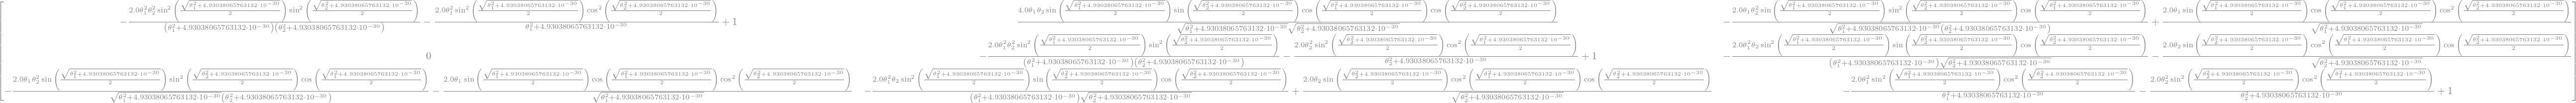

'Translation vector'

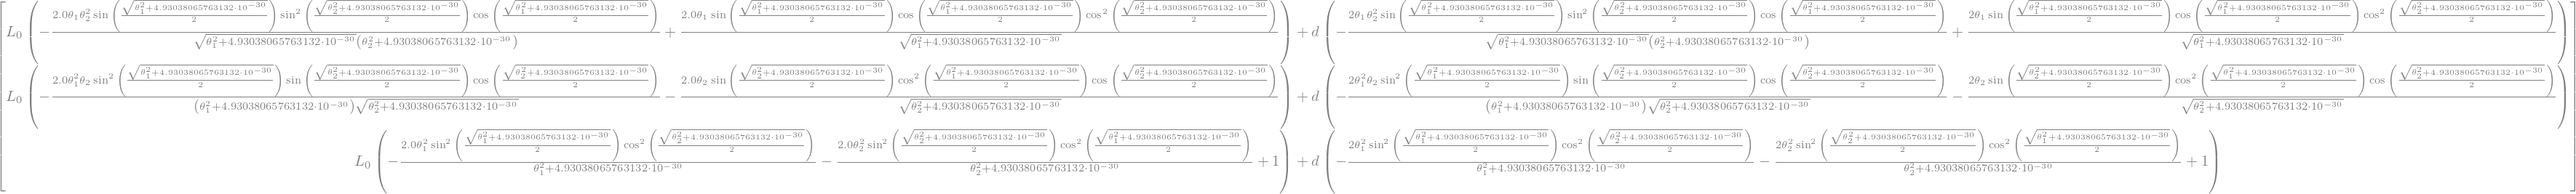

In [113]:
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()



epsilon = sf.numeric_epsilon  # Small number to handle singularities in Rot3.from_tangent
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)


display(f"End-Effector Pose:\n{end_effector_pose.simplify}")

# Rotation matrix

R = end_effector_pose[:3, :3]
display("Rotation Matrix:")
display(R)



# Translation vector
t = end_effector_pose[:3, 3]
display("Translation vector")
display(t)



# Calculating S Matrices

This cell defines a function calculate_S_matrix that computes the 4x4 matrix [S_i] from a 6-dimensional screw axis. It then calculates these matrices for each joint of the 3-DOF robot and displays them. These matrices represent the infinitesimal motion of each joint and are used in the Product of Exponentials formula for forward kinematics.

'[S_0] matrix:'

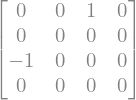

'[S_1] matrix:'

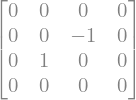

'[S_2] matrix:'

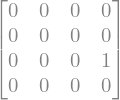

In [69]:
import sympy as sp

def calculate_S_matrix(screw_axis):
    """
    Calculate the 4x4 matrix [S_i] from a 6-dimensional screw axis.
    
    Args:
    screw_axis (list): A 6-dimensional list representing [ω_x, ω_y, ω_z, v_x, v_y, v_z]
    
    Returns:
    sp.Matrix: The 4x4 matrix [S_i]
    """
    omega = sp.Matrix(screw_axis[:3])
    v = sp.Matrix(screw_axis[3:])
    
    omega_skew = sp.Matrix([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])
    
    S_matrix = sp.Matrix.zeros(4)
    S_matrix[:3, :3] = omega_skew
    S_matrix[:3, 3] = v
    
    return S_matrix

# Setup the robot
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

# Calculate [S_i] for each joint
S_matrices = []
for i in range(3):
    screw_axis = screw_axes_params[f'S{i+1}']
    S_matrix = calculate_S_matrix(screw_axis)
    S_matrices.append(S_matrix)

# Display the results
for i, S_matrix in enumerate(S_matrices):
    display(f"[S_{i}] matrix:")
    display(S_matrix)

# Verifying Forward Kinematics

This cell defines functions to verify the correctness of the forward kinematics calculations. The verify_forward_kinematics function takes joint angle values and an expected end-effector position, computes the actual position using the forward kinematics function, and compares it with the expected position.
The cell then runs four test cases for different robot configurations:
- Robot arm rotates around q1 for 90 degree
- Robot arm straight up
- Robot arm bent 90 degrees around q2
- Robot arm straight up  with extension

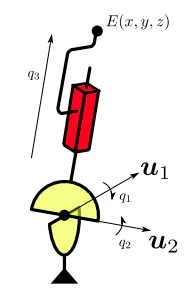


For each test case, it displays the configuration, expected position, actual position, and whether they match within a small tolerance.
This verification helps ensure that the forward kinematics calculations are correct for various robot poses.


'Configuration:'

'q1 = 1.57, q2 = 0.00, q3 = 0.00'

'Expected position:'

'Actual position:'

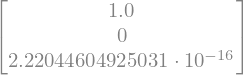

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 0.00, q3 = 0.00'

'Expected position:'

'Actual position:'

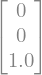

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 1.57, q3 = 0.00'

'Expected position:'

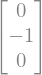

'Actual position:'

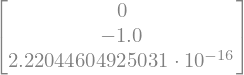

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 0.00, q3 = 0.50'

'Expected position:'

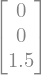

'Actual position:'

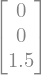

'Match:'

'Yes'

'---'

In [114]:
import math

def is_close(v1, v2, epsilon=1e-6):
    return all(abs(a - b) < epsilon for a, b in zip(v1, v2))

def verify_forward_kinematics(q1_val, q2_val, q3_val, expected_position):
    # Setup the robot
    joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

    # Create a dictionary for substitutions
    substitutions = {
        joint_angles['q1']: q1_val,
        joint_angles['q2']: q2_val,
        joint_angles['q3']: q3_val,
        L0: 1.0  # Assuming L0 = 1 unit
    }

    # Compute forward kinematics
    epsilon = sf.numeric_epsilon
    end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

    # Apply substitutions
    end_effector_pose_subbed = end_effector_pose.subs(substitutions)

    # Extract the position vector
    position = end_effector_pose_subbed[:3, 3].evalf()

    # Compare with expected position
    expected = sf.V3(expected_position)
    actual = sf.V3(position)
    is_close_result = is_close(actual, expected, epsilon=1e-6)

    display("Configuration:")
    display(f"q1 = {q1_val:.2f}, q2 = {q2_val:.2f}, q3 = {q3_val:.2f}")

    display("Expected position:")
    display(expected)

    display("Actual position:")
    display(actual)

    display("Match:")
    display("Yes" if is_close_result else "No")

    display("---")

# Test cases
verify_forward_kinematics(math.pi/2, 0, 0, [1, 0, 0])  # Robot arm rotates around q1 for 90 degree
verify_forward_kinematics(0, 0, 0, [0, 0, 1])  # Robot arm straight up
verify_forward_kinematics(0, math.pi/2, 0, [0, -1, 0])  # Robot arm bent 90 degrees around q2
verify_forward_kinematics(0, 0, 0.5, [0, 0, 1.5])  # Robot arm straight up  with extension

# Exporting code into maple for simplification



In [71]:
import sympy as sp
from sympy import sympify, maple_code, Symbol

def remove_small_values(expr, threshold=1e-10):
    if isinstance(expr, sp.Number):
        return sp.Float(0) if abs(expr) < threshold else expr
    elif isinstance(expr, sp.Add):
        return sp.Add(*[remove_small_values(arg, threshold) for arg in expr.args])
    elif isinstance(expr, sp.Mul):
        cleaned_args = [remove_small_values(arg, threshold) for arg in expr.args]
        if any(arg == 0 for arg in cleaned_args):
            return sp.Float(0)
        return sp.Mul(*cleaned_args)
    elif isinstance(expr, sp.Pow):
        base = remove_small_values(expr.base, threshold)
        exp = remove_small_values(expr.exp, threshold)
        if exp == 0.5:  # This is a square root
            if isinstance(base, sp.Add):
                significant_terms = [term for term in base.args if not (isinstance(term, sp.Number) and abs(term) < threshold)]
                if len(significant_terms) == 0:
                    return sp.Float(0)
                elif len(significant_terms) == 1:
                    return sp.sqrt(significant_terms[0])
                else:
                    return sp.sqrt(sp.Add(*significant_terms))
            return sp.sqrt(base)
        return base ** exp
    elif isinstance(expr, (sp.sin, sp.cos, sp.tan)):
        return expr.func(remove_small_values(expr.args[0], threshold))
    else:
        return expr

def clean_expression(expr):
    cleaned_expr = remove_small_values(expr)
    return sp.simplify(cleaned_expr)

def symforce_to_maple(expression):
    sympy_expr = sympify(str(expression))
    epsilon = Symbol('epsilon')
    sympy_expr = sympy_expr.subs(sf.numeric_epsilon, epsilon)
    cleaned_expr = clean_expression(sympy_expr)
    maple_str = maple_code(cleaned_expr)
    return maple_str

joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()
epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

maple_expressions = []
maple_expressions.append("# Robot Kinematics in Maple\n")
maple_expressions.append("with(LinearAlgebra):")
maple_expressions.append("# Assume positive values for parameters\n assume(theta1 > 0, theta2 > 0, d > 0, L0 > 0):")
maple_expressions.append("T := Matrix(4,4):")

for i in range(4):
    for j in range(4):
        maple_expr = symforce_to_maple(end_effector_pose[i, j])
        maple_expressions.append(f"T[{i+1},{j+1}] := {maple_expr};")

maple_expressions.append("T := simplify(T);")
maple_expressions.append("print(\"Full Transformation Matrix:\");")
maple_expressions.append("print(T);")

# Extract and print rotation matrix
maple_expressions.append("\n# Extract Rotation Matrix")
maple_expressions.append("R := SubMatrix(T, 1..3, 1..3);")
maple_expressions.append("print(\"Rotation Matrix:\");")
maple_expressions.append("print(R);")

# Extract and print position vector
maple_expressions.append("\n# Extract Position Vector")
maple_expressions.append("p := Vector([T[1,4], T[2,4], T[3,4]]);")
maple_expressions.append("print(\"Position Vector:\");")
maple_expressions.append("print(p);")

# Write to Maple worksheet file
with open("robot_kinematics.mw", "w") as f:
    for expr in maple_expressions:
        f.write(expr + "\n")

print("Maple worksheet 'robot_kinematics.mw' has been generated.")

Maple worksheet 'robot_kinematics.mw' has been generated.


# Inverse Kinematics

Inverse Kinematics Solution:


'Solution set 1:'

'theta1 ='

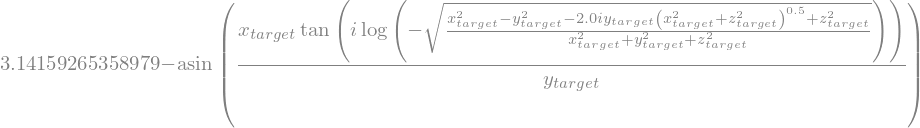

'theta2 ='

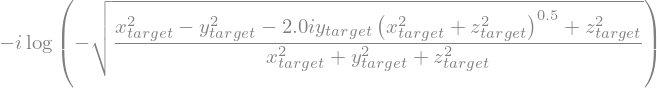

'd ='

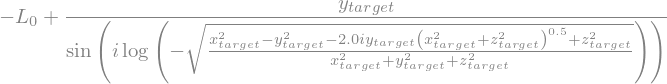

'Solution set 2:'

'theta1 ='

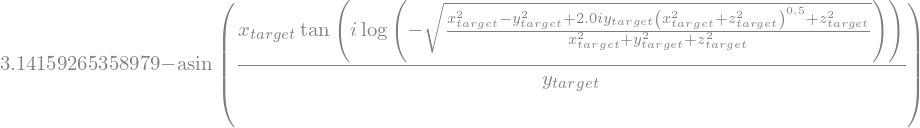

'theta2 ='

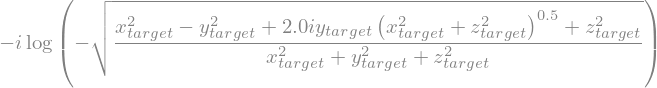

'd ='

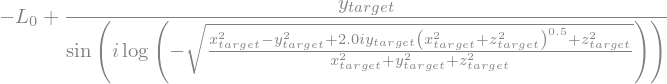

'Solution set 3:'

'theta1 ='

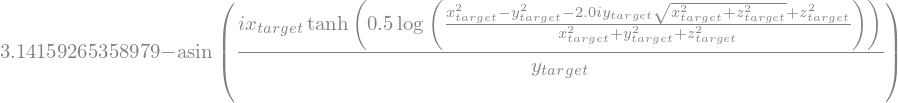

'theta2 ='

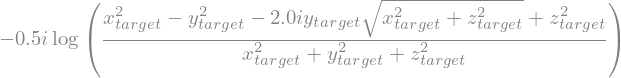

'd ='

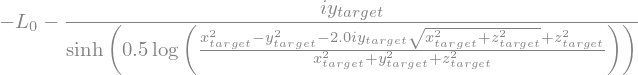

'Solution set 4:'

'theta1 ='

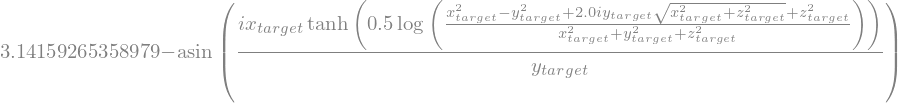

'theta2 ='

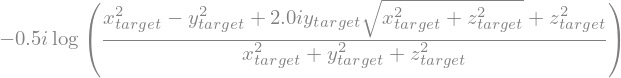

'd ='

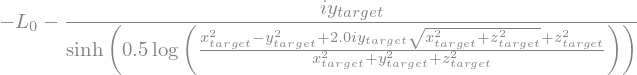

'Solution set 5:'

'theta1 ='

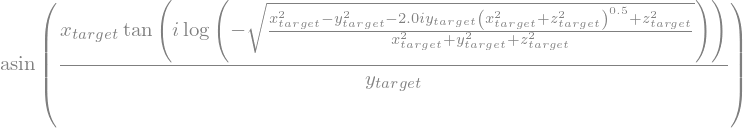

'theta2 ='

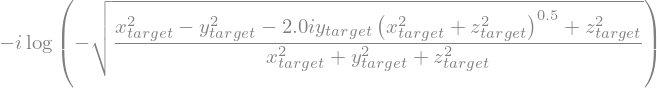

'd ='

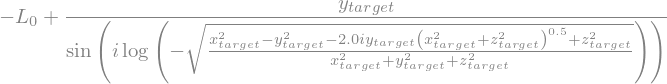

'Solution set 6:'

'theta1 ='

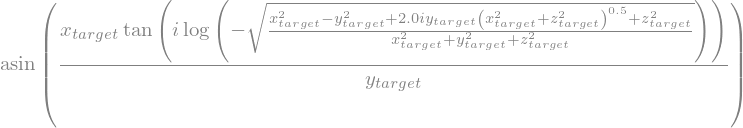

'theta2 ='

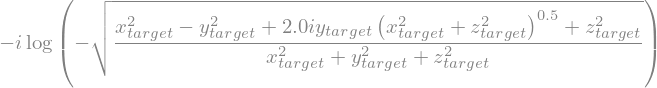

'd ='

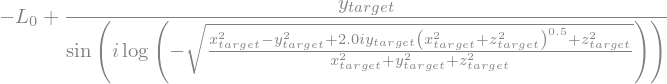

'Solution set 7:'

'theta1 ='

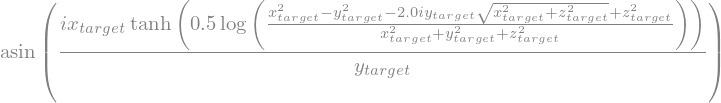

'theta2 ='

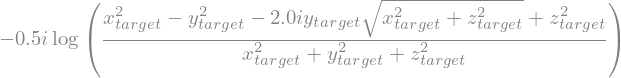

'd ='

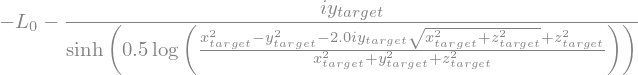

'Solution set 8:'

'theta1 ='

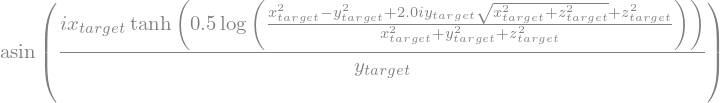

'theta2 ='

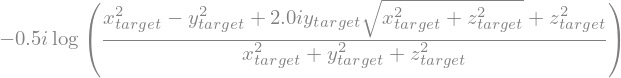

'd ='

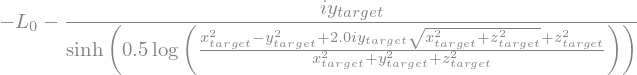

In [101]:
def solve_inverse_kinematics():
    # Setup the robot
    joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()
    
    # Compute forward kinematics
    epsilon = sf.numeric_epsilon
    end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)
    
    # Extract the position components
    x = sf.simplify(sf.expand(clean_expression(end_effector_pose[0, 3]),Trig=True))
    y = clean_expression(end_effector_pose[1, 3])
    z = clean_expression(end_effector_pose[2, 3])
    
    
    # Define symbolic variables for the target position
    x_target, y_target, z_target = sf.symbols("x_target y_target z_target")
    
    # Define the equations to solve
    eq1 = x - x_target
    eq2 = y - y_target
    eq3 = z - z_target
    
    # Extract the joint angle symbols
    theta1 = joint_angles['q1']
    theta2 = joint_angles['q2']
    d = joint_angles['q3']
    
    # Solve the system of equations
    solution = sf.solve([eq1, eq2, eq3], [theta1, theta2, d])
    
    return solution

# Solve and print the results
ik_solution = solve_inverse_kinematics()
print("Inverse Kinematics Solution:")
for i, sol in enumerate(ik_solution, 1):
    display(f"Solution set {i}:")
    display("theta1 =", sol[0])
    display("theta2 =", sol[1])
    display("d =", sol[2])
    print()

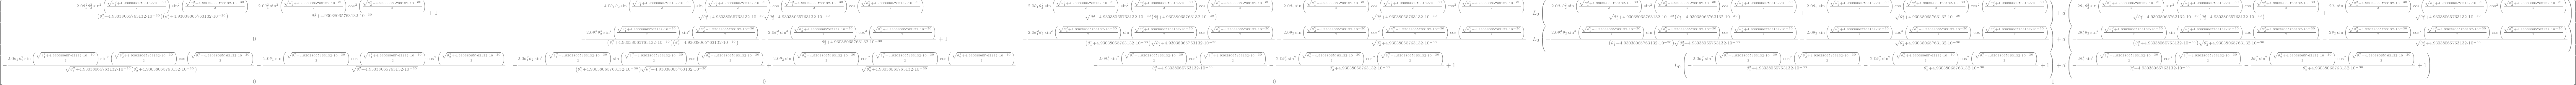

# Work Space Analyziz

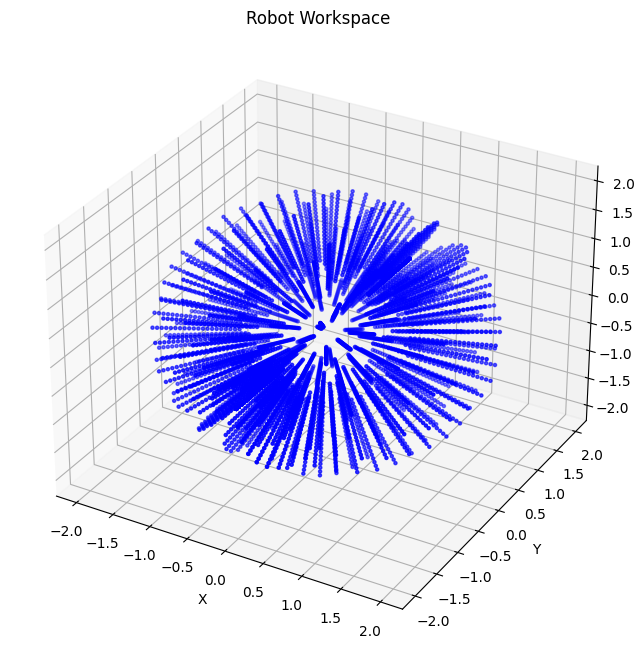

Workspace boundaries:
X: [-1.99, 1.99]
Y: [-2.00, 2.00]
Z: [-1.99, 1.97]
Approximate workspace volume: 62.91 cubic units


In [106]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Extract the position components
x = sf.simplify(sf.expand(clean_expression(end_effector_pose[0, 3]),Trig=True))
y = clean_expression(end_effector_pose[1, 3])
z = clean_expression(end_effector_pose[2, 3])
    

# Create lambda functions for x, y, z
x_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), x)
y_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), y)
z_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), z)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 20)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 20)
d_range = np.linspace(0, 1, 20)  # Assuming d can extend up to 1 unit

# Set L0 value
L0_value = 1.0  # Adjust as needed

workspace_points = []

for theta1 in theta1_range:
    for theta2 in theta2_range:
        for d in d_range:
            x_val = x_func(theta1, theta2, d, L0_value)
            y_val = y_func(theta1, theta2, d, L0_value)
            z_val = z_func(theta1, theta2, d, L0_value)
            workspace_points.append((x_val, y_val, z_val))

# Convert to numpy array for easier manipulation
workspace_points = np.array(workspace_points)

# Visualize the workspace
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(workspace_points[:, 0], workspace_points[:, 1], workspace_points[:, 2], c='b', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace')

plt.show()

# Analyze workspace characteristics
x_min, x_max = np.min(workspace_points[:, 0]), np.max(workspace_points[:, 0])
y_min, y_max = np.min(workspace_points[:, 1]), np.max(workspace_points[:, 1])
z_min, z_max = np.min(workspace_points[:, 2]), np.max(workspace_points[:, 2])

print(f"Workspace boundaries:")
print(f"X: [{x_min:.2f}, {x_max:.2f}]")
print(f"Y: [{y_min:.2f}, {y_max:.2f}]")
print(f"Z: [{z_min:.2f}, {z_max:.2f}]")

# Approximate workspace volume
volume = (x_max - x_min) * (y_max - y_min) * (z_max - z_min)
print(f"Approximate workspace volume: {volume:.2f} cubic units")

array([[-2.46519033e-32,  1.00000000e+00, -2.22044605e-16],
       [-2.59493719e-32,  1.05263158e+00, -2.33731163e-16],
       [-2.72468405e-32,  1.10526316e+00, -2.45417721e-16],
       ...,
       [ 4.67088694e-32, -1.89473684e+00, -4.20716094e-16],
       [ 4.80063380e-32, -1.94736842e+00, -4.32402652e-16],
       [ 4.93038066e-32, -2.00000000e+00, -4.44089210e-16]])

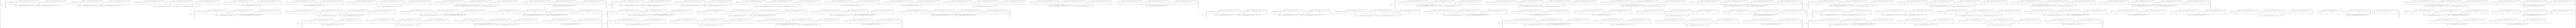

In [137]:
# Use your joint variables
theta1 = joint_angles['q1']
theta2 = joint_angles['q2']
d = joint_angles['q3']


# Create the symbolic vector using your joint variables
joint_angles_sym = sf.V3(theta1, theta2, d)
joint_angles_sym

# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

jacobian

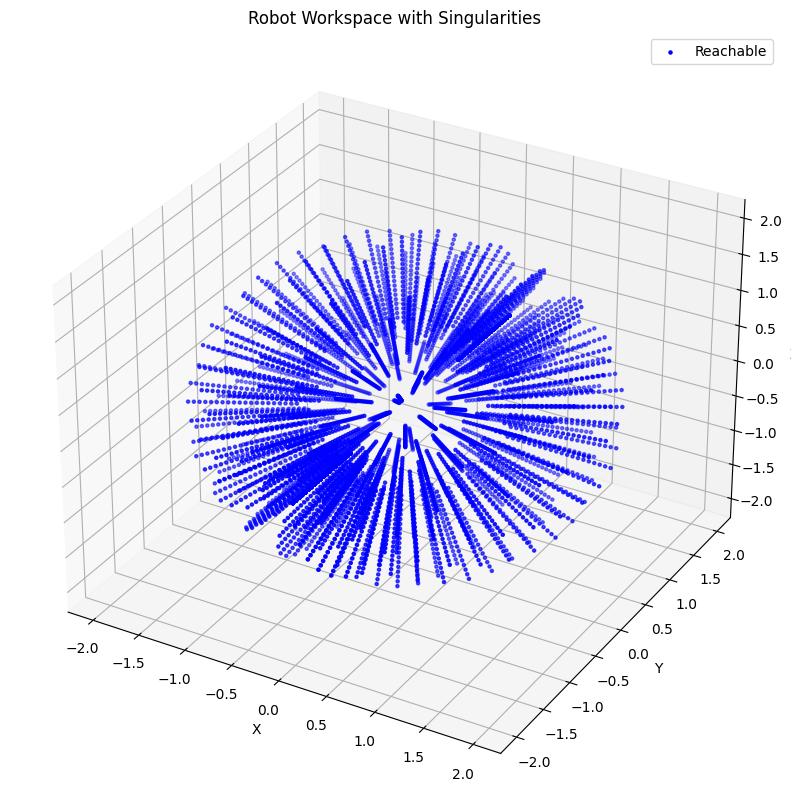

Total points: 8000
Singular points: 0
Percentage of singular configurations: 0.00%


In [139]:
import symforce.symbolic as sf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp

# Setup the robot
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

# Extract the joint angle symbols
theta1 = joint_angles['q1']
theta2 = joint_angles['q2']
d = joint_angles['q3']

# Create the symbolic vector using your joint variables
joint_angles_sym = sf.V3(theta1, theta2, d)

# Use your calculated end-effector pose
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)
jacobian_sympy = sp.Matrix(jacobian)

# Create lambda functions for position and Jacobian
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)
jacobian_func = sp.lambdify([theta1, theta2, d, L0], jacobian_sympy)

def is_singular(J, threshold=1e-6):
    _, s, _ = np.linalg.svd(J)
    return np.any(s < threshold)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 20)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 20)
d_range = np.linspace(0, 1, 20)

L0_value = 1.0  # Adjust as needed

workspace_points = []
singular_points = []

for theta1_val in theta1_range:
    for theta2_val in theta2_range:
        for d_val in d_range:
            position = position_func(theta1_val, theta2_val, d_val, L0_value)
            J = jacobian_func(theta1_val, theta2_val, d_val, L0_value)
            
            if is_singular(J):
                singular_points.append(position)
            else:
                workspace_points.append(position)

workspace_points = np.array(workspace_points)
singular_points = np.array(singular_points)


# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(workspace_points[:, 0], workspace_points[:, 1], workspace_points[:, 2], c='b', marker='.', label='Reachable')
if len(singular_points) > 0:
    ax.scatter(singular_points[:, 0], singular_points[:, 1], singular_points[:, 2], c='r', marker='.', label='Singular')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace with Singularities')
ax.legend()

plt.show()

# Analyze workspace and singularities
print(f"Total points: {len(workspace_points) + len(singular_points)}")
print(f"Singular points: {len(singular_points)}")
print(f"Percentage of singular configurations: {len(singular_points) / (len(workspace_points) + len(singular_points)) * 100:.2f}%")

if len(singular_points) > 0:
    singular_mean = np.mean(singular_points, axis=0)
    print(f"Center of singular region: ({singular_mean[0]:.2f}, {singular_mean[1]:.2f}, {singular_mean[2]:.2f})")

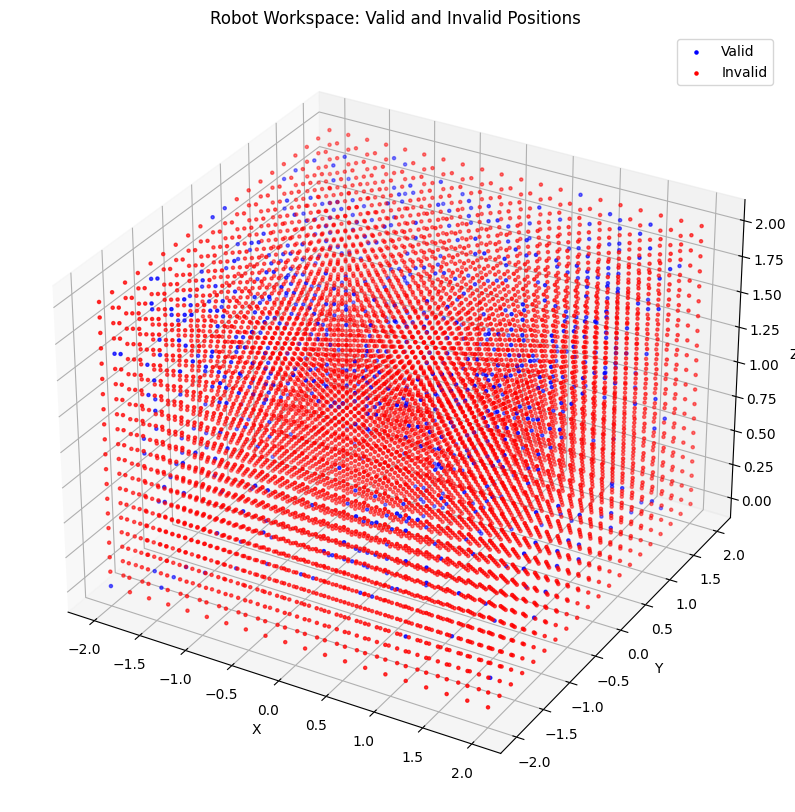

Total points sampled: 8000
Valid points: 741
Invalid points: 7259
Percentage of valid workspace: 9.26%

Valid workspace boundaries:
X: [-2.00, 2.00]
Y: [-2.00, 2.00]
Z: [0.00, 2.00]

Invalid points center:
(-0.00, 0.01, 0.97)


In [150]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

def has_real_solution(solutions, tolerance=1e-9):
    """
    Check if at least one solution in the set is real (imaginary parts are close to zero).
    
    Args:
    solutions: A list of solutions to check
    tolerance: The maximum allowed absolute value for the imaginary part (default: 1e-9)
    
    Returns:
    bool: True if at least one solution is considered real, False otherwise
    """
    def is_real(solution):
        return all(abs(sp.im(s).evalf()) < tolerance for s in solution)
    
    return any(is_real(solution) for solution in solutions)


# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)

# Create lambda function for position
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)

# Define ranges for workspace sampling
x_range = np.linspace(-2, 2, 20)
y_range = np.linspace(-2, 2, 20)
z_range = np.linspace(0, 2, 5)

L0_value = 1.0  # Adjust as needed

valid_points = []
invalid_points = []

# Extract x, y, z symbols from the end-effector position
x, y, z = sp.symbols('x_target y_target z_target')

for x_val in x_range:
    for y_val in y_range:
        for z_val in z_range:
            # Substitute the current x, y, z values into the inverse kinematics solutions
            substituted_solutions = [
                [s.subs({x: x_val, y: y_val, z: z_val, L0: L0_value}) for s in sol]
                for sol in ik_solution
            ]
            
            # Check if any solution is real
            if has_real_solution(substituted_solutions):
                valid_points.append((x_val, y_val, z_val))
            else:
                invalid_points.append((x_val, y_val, z_val))

valid_points = np.array(valid_points)
invalid_points = np.array(invalid_points)

# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

if len(valid_points) > 0:
    ax.scatter(valid_points[:, 0], valid_points[:, 1], valid_points[:, 2], c='b', marker='.', label='Valid')
if len(invalid_points) > 0:
    ax.scatter(invalid_points[:, 0], invalid_points[:, 1], invalid_points[:, 2], c='r', marker='.', label='Invalid')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace: Valid and Invalid Positions')
ax.legend()

plt.show()

# Analyze workspace
total_points = len(valid_points) + len(invalid_points)
print(f"Total points sampled: {total_points}")
print(f"Valid points: {len(valid_points)}")
print(f"Invalid points: {len(invalid_points)}")
print(f"Percentage of valid workspace: {len(valid_points) / total_points * 100:.2f}%")

if len(valid_points) > 0:
    print("\nValid workspace boundaries:")
    print(f"X: [{np.min(valid_points[:, 0]):.2f}, {np.max(valid_points[:, 0]):.2f}]")
    print(f"Y: [{np.min(valid_points[:, 1]):.2f}, {np.max(valid_points[:, 1]):.2f}]")
    print(f"Z: [{np.min(valid_points[:, 2]):.2f}, {np.max(valid_points[:, 2]):.2f}]")

if len(invalid_points) > 0:
    print("\nInvalid points center:")
    invalid_center = np.mean(invalid_points, axis=0)
    print(f"({invalid_center[0]:.2f}, {invalid_center[1]:.2f}, {invalid_center[2]:.2f})")

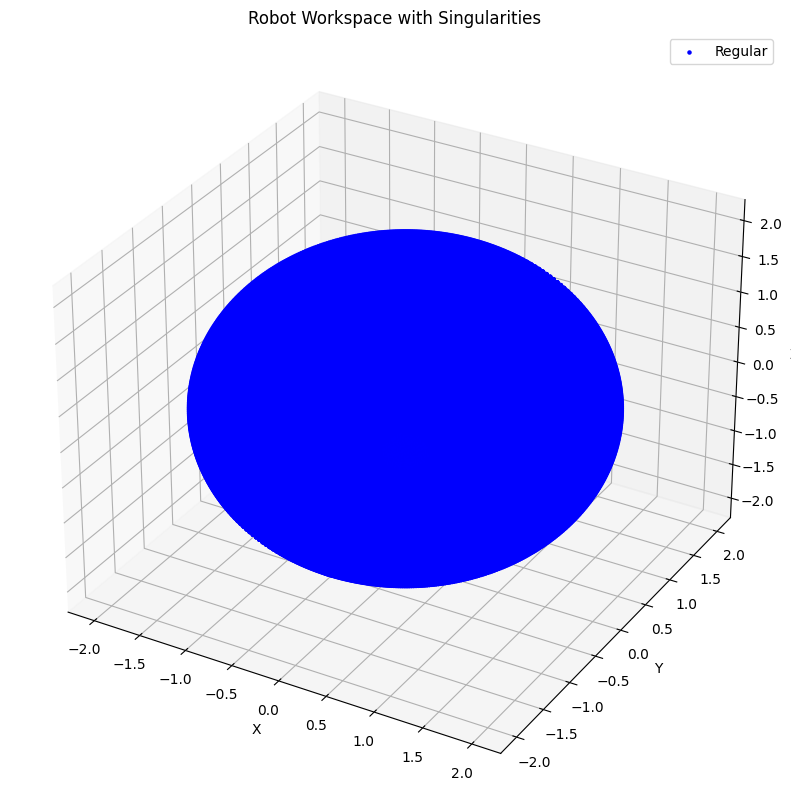

Total points: 400000
Regular points: 400000
Singular points: 0
Percentage of singular configurations: 0.00%


In [145]:
# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)
jacobian_sympy = sp.Matrix(jacobian)

# Create lambda functions for position and Jacobian
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)
jacobian_func = sp.lambdify([theta1, theta2, d, L0], jacobian_sympy)

def is_singular(J, threshold=1e-6):
    # Check if the Jacobian is singular
    _, s, _ = np.linalg.svd(J)
    return np.any(s < threshold)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 200)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 200)
d_range = np.linspace(0, 1, 10)

L0_value = 1.0  # Adjust as needed

regular_points = []
singular_points = []

for theta1_val in theta1_range:
    for theta2_val in theta2_range:
        for d_val in d_range:
            # Calculate position and Jacobian
            position = position_func(theta1_val, theta2_val, d_val, L0_value)
            J = jacobian_func(theta1_val, theta2_val, d_val, L0_value)
            
            # Check if the configuration is singular
            if is_singular(J):
                singular_points.append(position)
            else:
                regular_points.append(position)

regular_points = np.array(regular_points)
singular_points = np.array(singular_points)

# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(regular_points[:, 0], regular_points[:, 1], regular_points[:, 2], c='b', marker='.', label='Regular')
if len(singular_points) > 0:
    ax.scatter(singular_points[:, 0], singular_points[:, 1], singular_points[:, 2], c='r', marker='.', label='Singular')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace with Singularities')
ax.legend()

plt.show()

# Analyze workspace and singularities
total_points = len(regular_points) + len(singular_points)
print(f"Total points: {total_points}")
print(f"Regular points: {len(regular_points)}")
print(f"Singular points: {len(singular_points)}")
print(f"Percentage of singular configurations: {len(singular_points) / total_points * 100:.2f}%")

if len(singular_points) > 0:
    singular_mean = np.mean(singular_points, axis=0)
    print(f"\nCenter of singular region: ({singular_mean[0]:.2f}, {singular_mean[1]:.2f}, {singular_mean[2]:.2f})")